In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pathlib
import os 
import numpy as np
from string import ascii_uppercase
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from glob import glob
from pandas import DataFrame
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Conv2D,MaxPooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
import seaborn as sn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, accuracy_score, f1_score
import keras
from sklearn.utils import class_weight
import imageio
import random
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras import backend as K
#from yellowbrick.classifier import ClassificationReport

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Endereço dos conjuntos

In [3]:
path = '../../data_especular_crop/'
training_dir = str(path)+'train_imagesAmostras'
validation_dir = str(path)+'val_images'
test_dir = str(path)+'test_images'

img = imageio.imread(str(path)+'train_images/confluente/0.png')
sizeX, sizeY,_ = img.shape
print("Tamanho original: ")
print(sizeX, sizeY)

sizeX = sizeX//2#256
sizeY = sizeY//2#256


print("Tamanho definido: ")
print(sizeX, sizeY)


batch_size = 64
epocas = 20


Tamanho original: 
460 245
Tamanho definido: 
230 122


In [4]:
def visualizarOrganizacao(diretorio, fase):
    data_dir = pathlib.Path(diretorio)
    # Verificando quantas imagens tem nos diretórios
    image_count = len(list(data_dir.glob('*/*.png')))
    print("Quantidade total de Imagens no "+str(fase)+": "+ str(image_count))

    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
    # Print das categorias 
    print('Classes/rótulos: ', CLASS_NAMES)

    # Visualizando o tamanho de cada classe
    fnames = []
    for classes in CLASS_NAMES:
        images_folder = os.path.join(data_dir, classes)
        file_names    = os.listdir(images_folder)
        full_path     = [os.path.join(images_folder, file_name) for file_name in file_names]
        fnames.append(full_path)

        tamanho_classes = [len(f) for f in fnames]

    explode = (0.4, 0.4, 0, 0.4)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(tamanho_classes, explode=explode, labels=CLASS_NAMES, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    return tamanho_classes, CLASS_NAMES

In [5]:
# Função para exibir o desempenho do modelo em treino e teste
def plot_model(model_name, history, epochs):

    print(model_name)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2 ,1)
    plt.plot(np.arange(0, len(history['precision_m'])), history['precision_m'], 'r')
    plt.plot(np.arange(1, len(history['val_precision_m'])+1), history['val_precision_m'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Precision vs. Validation Precision')
    plt.xlabel('Nro de Epochs')
    plt.ylabel('Precision')
    plt.legend(['train', 'validation'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(history['recall_m'])+1), history['recall_m'], 'r')
    plt.plot(np.arange(1, len(history['val_recall_m'])+1), history['val_recall_m'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Recall vs. Validation Recall')
    plt.xlabel('Nro de Epochs')
    plt.ylabel('Recall')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [6]:
def prepareData(training_dir, validation_dir, test_dir):
    folders = glob(training_dir + '/*')
    num_classes = len(folders) 

    train_datagen = ImageDataGenerator(
        rescale=1./255,
       # rotation_range=180,
      #  rescale=1./255,
       # width_shift_range=0.2,
      #  height_shift_range=0.2,
       # shear_range=0.2, #cisalhamento
       # zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True
        #fill_mode='nearest'
        )
    
    # exemplo de geração de imagens
    img = load_img(str(path)+'train_images/confluente/0.png')  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
  #  print(x)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    
    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in train_datagen.flow(x, batch_size=1,
                                    save_to_dir=str(path)+'/preview', 
                                    save_prefix='con', 
                                    save_format='jpeg'):
     #   print(batch)
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

    train_datagen = ImageDataGenerator(rescale=1./255) 
    val_datagen = ImageDataGenerator(rescale=1./255)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=(sizeX, sizeY),
         batch_size=batch_size,
        class_mode='categorical')  
   
   # print(train_generator.flow)
    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(sizeX, sizeY),
        batch_size=batch_size,
        class_mode='categorical')
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(sizeX, sizeY),
        batch_size=batch_size,
        class_mode='categorical')    
    

    
    
    return train_generator, validation_generator, test_generator, num_classes  

In [7]:
def plotMatrix(data, model, fase, tipoM):    
    Y_pred = model.predict_generator(data)
    
    y_pred = np.argmax(Y_pred, axis=1)
    
   # print(data.classes, y_pred)

    ax = sn.heatmap(confusion_matrix(data.classes, y_pred), 
                    annot=True, 
                    cmap='Blues',  fmt='g')
    ax.set_title('Matriz de confusão - '+ str(fase) + " - " + str(tipoM));          
    plt.show()
    
    print("Classification Report:")
    print(classification_report(data.classes, y_pred))    

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
def treinarInceptionV3(train_generator, validation_generator, test_generator, num_classes, epocas):
    
    IMAGE_SIZE = [sizeX, sizeY]  

    base_model = InceptionV3(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['acc',f1_m,precision_m, recall_m])

        # criar ponto de salvamento com base no melhor modelo obtido
    checkpointer = ModelCheckpoint(str(path)+'/pesos/BestCheckPointInceptionV3.hdf5', verbose=1,save_best_only=True)
   # stopper = EarlyStopping(monitor='val_acc',min_delta=0.1,patience=0,verbose=1,mode='auto')

    
    # train the model on the new data for a few epochs
    history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    epochs=epocas,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//batch_size,
                    shuffle = True,
                   # class_weight=class_weights,
                    callbacks=[checkpointer])    
    
    plot_model('Modelo Inception V3', history.history, epocas)
    
   # plotMatrix(train_generator, model, "treinamento", "Inception V3")
    
   # plotMatrix(test_generator, model, "teste", "Inception V3")
        
   # plotMatrix(validation_generator, model, "validação", "Inception V3")
        
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

    return model

In [10]:
def predizer(model, img_path, classe):
    img = image.load_img(img_path, target_size=(sizeX, sizeY))   
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_preprocessed)
    
    classePred = np.argmax(prediction)
    
    plt.title(str(classePred) + " - " + str(classe))
    plt.imshow(img)
    plt.show()

In [11]:
def predizerVariasAmostras(model):    
    imgURL = np.array([[[str(path)+'test_images/confluente/61.png'], [0]],
           [[str(path)+'test_images/esparsa/199.png'], [1]],
           [[str(path)+'test_images/integra/229.png'], [2]],
           [[str(path)+'test_images/rara/1332.png'], [3]]])
    plt.figure(figsize=(15,10))
    for i in range(imgURL.shape[0]):
        endereco = imgURL[i][0][0]
        classe = imgURL[i][1][0]
        
        plt.subplot(1,4,i+1)
        img = image.load_img(endereco, target_size=(sizeX, sizeY))   
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)
        prediction = model.predict(img_preprocessed)
    
        classePred = np.argmax(prediction)
    
        plt.title(str(classe) + " - " + str(classePred))
        plt.imshow(img)
    plt.show()
        

In [12]:
def predizerConjunto(model, classes, path, NomeModelo, NomeConjunto):
    predicoes = []
    classes = []
    predicoesN = []
    classesN = []
    directory_contents = os.listdir(path)
    for i in range(len(directory_contents)):
        diretorio = str(path) + "/" + str(directory_contents[i])+"/"
        lista = os.listdir(diretorio)
        for j in range(len(lista)):
            img_path = str(path) + "/" + str(directory_contents[i])+"/"+str(lista[j])
            img = image.load_img(img_path, target_size=(sizeX, sizeY))
            img_array = image.img_to_array(img)
            img_batch = np.expand_dims(img_array, axis=0)
            img_preprocessed = preprocess_input(img_batch)
            prediction = model.predict(img_preprocessed)
            classePred = np.argmax(prediction)
            classes.append(i)
            classesN.append(directory_contents[i])
            predicoes.append(classePred)
            predicoesN.append(directory_contents[classePred])

    ax = sn.heatmap(confusion_matrix(classes, predicoes), 
                    annot=True, 
                    cmap='Blues',  fmt='g')
    ax.set_title('Matriz de confusão - ' + str(NomeModelo) + " - " + str(NomeConjunto));          
    plt.show()

Found 3213 images belonging to 4 classes.
Found 437 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Epoch 1/20
50/50 [==============================] - 23s 465ms/step - loss: 1.1089 - acc: 0.5326 - f1_m: 0.4768 - precision_m: 0.5986 - recall_m: 0.4006 - val_loss: 3.0883 - val_acc: 0.1250 - val_f1_m: 0.1199 - val_precision_m: 0.1291 - val_recall_m: 0.1120

Epoch 00001: val_loss improved from inf to 3.08830, saving model to ../../data_especular_crop//pesos/BestCheckPointInceptionV3.hdf5
Epoch 2/20
50/50 [==============================] - 23s 458ms/step - loss: 0.6799 - acc: 0.7139 - f1_m: 0.6881 - precision_m: 0.7640 - recall_m: 0.6282 - val_loss: 0.8459 - val_acc: 0.6729 - val_f1_m: 0.6628 - val_precision_m: 0.7343 - val_recall_m: 0.6049

Epoch 00002: val_loss improved from 3.08830 to 0.84589, saving model to ../../data_especular_crop//pesos/BestCheckPointInceptionV3.hdf5
Epoch 3/20
50/50 [==============================] - 342s 7s/step - loss: 0.6086 - acc: 0.748

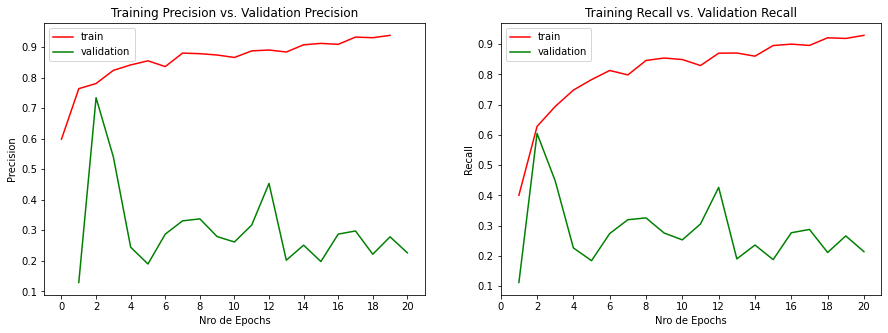

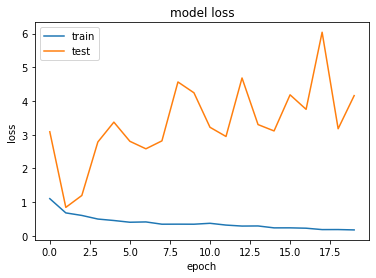

In [13]:
train_generator, validation_generator, test_generator, num_classes = prepareData(training_dir, validation_dir, test_dir)

modelo = treinarInceptionV3(train_generator, validation_generator, test_generator, num_classes, epocas)

modeloTreinado = "InceptionV3"

In [14]:
modelo.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 230, 122, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 114, 60, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 114, 60, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 114, 60, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 26, 12, 256)  0           mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 26, 12, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 26, 12, 64)   76800       activation_14[0][0]              
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 26, 12, 96)   82944       activation_17[0][0]              
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 26, 12, 64)   16384       average_pooling2d_2[0][0]        
__________

batch_normalization_30 (BatchNo (None, 12, 5, 96)    288         conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 12, 5, 384)   0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 12, 5, 96)    0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 12, 5, 288)   0           mixed2[0][0]                     
__________________________________________________________________________________________________
mixed3 (Concatenate)            (None, 12, 5, 768)   0           activation_27[0][0]              
                                                                 activation_30[0][0]              
          

activation_46 (Activation)      (None, 12, 5, 160)   0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 12, 5, 160)   122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 12, 5, 160)   179200      activation_46[0][0]              
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 12, 5, 160)   480         conv2d_42[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 12, 5, 160)   480         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation

conv2d_51 (Conv2D)              (None, 12, 5, 192)   147456      mixed5[0][0]                     
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 12, 5, 192)   215040      activation_53[0][0]              
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 12, 5, 192)   215040      activation_58[0][0]              
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 12, 5, 192)   147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 12, 5, 192)   576         conv2d_51[0][0]                  
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 12, 5, 192)   258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 12, 5, 192)   576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 12, 5, 192)   0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 12, 5, 192)   147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 12, 5, 192)   258048      activation_74[0][0]              
__________

activation_77 (Activation)      (None, 5, 2, 320)    0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 5, 2, 768)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5, 2, 768)    0           activation_83[0][0]              
                                                                 activation_84[0][0]              
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 5, 2, 192)    0           batch_normalization_85[0][0]     
__________________________________________________________________________________________________
mixed9 (Co

dense_1 (Dense)                 (None, 1024)         2098176     global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4)            4100        dense_1[0][0]                    
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd


def visualize_model(modelo):
    return SVG(model_to_dot(modelo).create(prog='dot', format='svg'))
visualize_model(modelo)

In [15]:
from keras.models import load_model
modelo.save(str(path)+'pesos/ColabLastPointInceptionV3.hdf5')

In [16]:
print("Avaliação do modelo")
print("Treinamento")
print(modelo.evaluate(train_generator, verbose=1))
print("teste")
print(modelo.evaluate(test_generator, verbose=1))

Avaliação do modelo
Treinamento
51/51 [==============================] - 456s 9s/step
[3.5578196048736572, 0.49922192096710205, 0.49764710664749146, 0.5045812129974365, 0.4909973442554474]
teste
7/7 [==============================] - 69s 10s/step
[4.606245517730713, 0.24367816746234894, 0.23515258729457855, 0.24069085717201233, 0.2300420105457306]
